In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 to label objectid in successive frames given bounding box in first frame. 

## Set-up

In [9]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import json

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


### Loading the SAM 2 video predictor

In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='orange', facecolor=(0, 0, 0, 0), lw=1))


def find_bounding_box(mask):
    # Get the row, col indices of all True (non-zero) pixels
    coords = np.argwhere(mask[0])
    
    # If the mask is empty, coords will be empty.
    # Otherwise, compute bounding box:
    if coords.size > 0:
        # coords[:, 0] are the y indices (rows), coords[:, 1] are the x indices (columns)
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
    
        box = np.array([int(x_min), int(y_min), int(x_max), int(y_max)], dtype=np.float32)
        # print("Bounding Box:", box)
        # box = np.array([1494, 349, 1857, 548], dtype=np.float32)
        # show_box(box, ax)
        return box
    else:
        print("Mask is empty, no bounding box found.")
        return None

def show_bounding_box(mask, ax):
    box = find_bounding_box(mask)
    if box is not None:
        show_box(box, ax)

In [152]:
# Get the bounding box from the annotation

In [217]:
def get_annotation_frame_box(frame_annotation, frame_width, frame_height):
    x_min = int(frame_annotation['x1'] / frame_annotation['width'] * frame_width)
    y_min = int(frame_annotation['y1'] / frame_annotation['height'] * frame_height)
    x_max = int(frame_annotation['x2'] / frame_annotation['width'] * frame_width)
    y_max = int(frame_annotation['y2'] / frame_annotation['height'] * frame_height)
    return [x_min, y_min, x_max, y_max] 

In [172]:
frame_width = 3840
frame_height = 2160

In [218]:
get_annotation_frame_box(frame_annotation, frame_width, frame_height)

[547, 1457, 750, 1530]

#### Select an example video

In [284]:
# Will apply SAM2 to annotate all frames given first frame annotation
def get_annotations_from_video_frames(video_dir, frame_annotation):
    # `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
    
    # scan all the JPEG frame names in this directory
    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    # take a look the first video frame
    frame_idx = 0
    
    # Get the height and width of first frame
    with Image.open(os.path.join(video_dir, frame_names[frame_idx])) as img:
        width, height = img.size  # img.size returns a tuple (width, height)
        print(f"Frame {frame_idx} - Width: {width}px, Height: {height}px")

    # Transform frame_annotation to initial bounding box
    init_box = get_annotation_frame_box(frame_annotation, width, height)
    
    # Initialise the state of the predictor
    inference_state = predictor.init_state(video_path=video_dir)

    # Now annotate first frame
    ann_frame_idx = 0  # the frame index we interact with
    ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)
    
    # Let's add a box at (x_min, y_min, x_max, y_max) e.g. (300, 0, 500, 400) to get started
    box = np.array(init_box, dtype=np.float32)
    
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        box=box,
    )

    # show the results on the current (interacted) frame
    plt.figure(figsize=(12, 9))
    plt.title(f"frame {ann_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
    show_bounding_box((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca())

    # run propagation throughout the video and collect the results in a dict
    annotations = {}
    # video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        # video_segments[out_frame_idx] = {
        #     out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        #     for i, out_obj_id in enumerate(out_obj_ids)
        # }
        out_mask = (out_mask_logits[0] > 0.0).cpu().numpy()
        box = find_bounding_box(out_mask)
        if box is not None:
            int_box = box.astype(np.int32)
            frame_num = int(frame_names[out_frame_idx].split('.')[0])
            # print('Frame: ', frame_num)
            annotation = bounding_box_to_annotation(int_box.tolist(), width, height, frame_annotation)
            # print('Annotation: ', annotation)
            annotations[frame_num] = annotation

    # Write the annotations dictionary to a JSON file
    output_json_path = os.path.join(video_dir, 'annotations.json')
    try:
        with open(output_json_path, 'w') as json_file:
            json.dump(annotations, json_file, indent=4)
        print(f"Annotations successfully written to {output_json_path}")

        return annotations
    except IOError as e:
        raise RuntimeError(f"Failed to write annotations to {output_json_path}: {e}")


In [270]:
def delete_image_file(frame_path, number):
    # Format the number with leading zeros to make it 5 digits
    filename = f"{number:05d}.jpg"
    # Construct the full file path
    file_path = os.path.join(frame_path, filename)
    
    # Delete the file
    os.remove(file_path)
    print(f"Deleted file: {file_path}")

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 1000 -vframes 100 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 1000` asks ffmpeg to start the JPEG file from `01000.jpg`.

To select only between designated frames we use the following:
```
ffmpeg -i <your_video>.mp4 -vf "select='between(n\,1000\,1099)'" -fps_mode passthrough -q:v 2 -start_number 1000 <output_dir>/'%05d.jpg'
```

This ffmpeg command works from shell:

```
ffmpeg -i /Users/kjr/Python/GeoVideoTagging/KJR-DATA-02/Goondoi/Missions/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V.MP4 -vf "select='between(n\,1000\,1099)'" -fps_mode passthrough -q:v 2 -start_number 994 /tmp/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V/'%05d.jpg'
```

For more precise start time:
```
ffmpeg -ss 33.67 -i example.mp4 -q:v 2 -start_number 1000 -vframes 100 frames/'%05d.jpg'

ffmpeg -ss 33.4005376344086 -i /Users/kjr/Python/GeoVideoTagging/KJR-DATA-02/Goondoi/Missions/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V.MP4 -q:v 2 -start_number 994 -vframes 100 /tmp/SAM2/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V_994_1003/%05d.jpg

-vf "fps=29.76"
```

In [254]:
def bounding_box_to_annotation(box, width, height, frame_annotation):
    [x1, y1, x2, y2] = box

    # Will provide a new annotation based on initial annotation, but with new location of bounding box
    new_annotation = {
        "x1": int(x1 / width * frame_annotation["width"]),
        "y1": int(y1 / height * frame_annotation["height"]),
        "x2": int(x2 / width * frame_annotation["width"]),
        "y2": int(y2 / height * frame_annotation["height"]),
        "width": frame_annotation["width"],
        "height": frame_annotation["height"],
        "type": frame_annotation["type"],
        "tags": frame_annotation["tags"]
    }
    
    return new_annotation

In [279]:
# Generate the frames from the video using ffmpeg
def generate_video_frames_using_ffmeg(src_video_file, video_fps, frame_start, frame_end, dst_frame_path):
    # Determine source video
    # src_video_path = os.path.join(gva_src, data_src, video_folder)
    # src_video_file = os.path.join(src_video_path, f"{video_file}.{video_extn}")

    # Check if it's a file
    if os.path.isfile(src_video_file):
        print(f"File '{src_video_file}' exists and is a file.")
    else:        
        # Raise an exception if the file does not exist
        raise FileNotFoundError(f"File '{src_video_file}' does not exist or is not a file.")

    # Determine target folder for frame generation
    # dst_frame_path = os.path.join(tmp_folder, video_folder, f"{video_file}_{frame_start}_{frame_end}")
    # Create the directory if it doesn't exist
    os.makedirs(dst_frame_path, exist_ok=True)

    # Setup ffmpeg command parameters
    start_time = f"{(frame_start - 1) / video_fps}"
    num_frames = f"{frame_end - frame_start + 1 + 1}"      # We add second +1 to account for ffmpeg -vframe repeats first frame
    frame_rate = '"fps={}"'.format(video_fps)
    start_number = f"{frame_start - 1}"                    # We -1 to account for ffmpeg -vframe repeats first frame
    # select_pattern = f"\"select=\'between(n,{frame_start},{frame_end})\'\""
    output_pattern = f"{dst_frame_path}/%05d.jpg"

    # ffmpeg -vstart option has a side effect that first frame is duplicated, and frames are then one behind
    # We patch this by labelling output one frame earlier, then will delete the first frame
    
    # cmd_arr = ['ffmpeg', '-i', src_video_file, '-vf', select_pattern, '-fps_mode', 'passthrough', '-q:v', '2', '-start_number', f"{frame_start}", output_pattern]
    cmd_arr = ['ffmpeg', '-ss', start_time, '-i', src_video_file, '-q:v', '2', '-start_number', start_number, '-vf', frame_rate, '-vframes', num_frames, output_pattern]
    ffmpeg_cmd = ' '.join(cmd_arr)
    print('Execute ffmpeg: ', ffmpeg_cmd)

    # Run ffmpeg
    ffmpeg_exit_code = os.system(ffmpeg_cmd)
    print('Exit Code ffmpeg:', ffmpeg_exit_code)
    if exit_code != 0:
        raise RuntimeError(f"FFmpeg command failed with exit code {exit_code}")

    # Delete the first frame as duplicate from -vframe option
    delete_image_file(dst_frame_path, int(start_number))
    

## Generate bounding box for first frame

We need to convert the GVA annotation to the bounding box to set for first frame.

## Pull all routines together

In [289]:
gva_src = '/Users/kjr/Python/GeoVideoTagging/'
data_src = 'KJR-DATA-02/Goondoi/Missions/'
video_folder = 'Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/'
video_file = 'DJI_20241130073900_0001_V'
video_extn = 'MP4'
video_fps = 29.76
frame_start = 994
frame_end = 1093
tmp_folder = '/tmp/SAM2/'
frame_annotation = {
        "x1": 105,
        "y1": 280,
        "x2": 144,
        "y2": 294,
        "id": 0,
        "width": 737,
        "height": 415,
        "type": "rectangle",
        "tags": [
            "vessel"
        ],
        "name": 1,
        "interpolated": False,
        "objectid": "pilot1",
        "depth": 260
    }

In [290]:
src_video_file = os.path.join(gva_src, data_src, video_folder, f"{video_file}.{video_extn}")
dst_frame_path = os.path.join(tmp_folder, video_folder, f"{video_file}_{frame_start}_{frame_end}")
generate_video_frames_using_ffmeg(src_video_file, video_fps, frame_start, frame_end, dst_frame_path)

File '/Users/kjr/Python/GeoVideoTagging/KJR-DATA-02/Goondoi/Missions/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V.MP4' exists and is a file.
Execute ffmpeg:  ffmpeg -ss 33.36693548387097 -i /Users/kjr/Python/GeoVideoTagging/KJR-DATA-02/Goondoi/Missions/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V.MP4 -q:v 2 -start_number 993 -vf "fps=29.76" -vframes 101 /tmp/SAM2/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V_994_1093/%05d.jpg


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

Exit Code ffmpeg: 0
Deleted file: /tmp/SAM2/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V_994_1093/00993.jpg


[out#0/image2 @ 0x600003b50000] video:65669KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: unknown
frame=  101 fps= 81 q=2.0 Lsize=N/A time=00:00:03.39 bitrate=N/A dup=1 drop=0 speed=2.72x    


Frame 0 - Width: 3840px, Height: 2160px


propagate in video: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Annotations successfully written to /tmp/SAM2/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V_994_1093/annotations.json


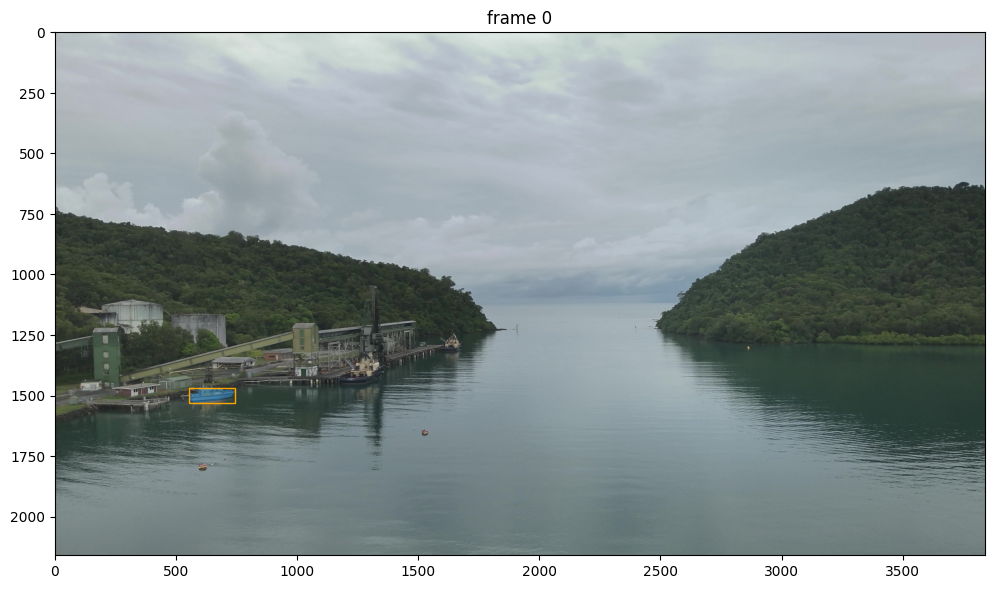

In [291]:
# video_dir = "/private/tmp/SAM2/Tour_20241128/DJI_202411300738_001_Goondoi-flights-Innisfail/DJI_20241130073900_0001_V_994_1003/"

annotations = get_annotations_from_video_frames(dst_frame_path, frame_annotation)

Initial frame_annotation bounding box:
```
[547, 1457, 750, 1530]
```

In [286]:
annotations

{994: {'x1': 106,
  'y1': 281,
  'x2': 142,
  'y2': 294,
  'width': 737,
  'height': 415,
  'type': 'rectangle',
  'tags': ['vessel']},
 995: {'x1': 118,
  'y1': 281,
  'x2': 158,
  'y2': 292,
  'width': 737,
  'height': 415,
  'type': 'rectangle',
  'tags': ['vessel']},
 996: {'x1': 137,
  'y1': 280,
  'x2': 172,
  'y2': 292,
  'width': 737,
  'height': 415,
  'type': 'rectangle',
  'tags': ['vessel']},
 997: {'x1': 148,
  'y1': 280,
  'x2': 182,
  'y2': 290,
  'width': 737,
  'height': 415,
  'type': 'rectangle',
  'tags': ['vessel']},
 998: {'x1': 156,
  'y1': 279,
  'x2': 190,
  'y2': 292,
  'width': 737,
  'height': 415,
  'type': 'rectangle',
  'tags': ['vessel']},
 999: {'x1': 162,
  'y1': 279,
  'x2': 195,
  'y2': 291,
  'width': 737,
  'height': 415,
  'type': 'rectangle',
  'tags': ['vessel']},
 1000: {'x1': 165,
  'y1': 279,
  'x2': 201,
  'y2': 291,
  'width': 737,
  'height': 415,
  'type': 'rectangle',
  'tags': ['vessel']},
 1001: {'x1': 171,
  'y1': 278,
  'x2': 205,
  

In [287]:
annotations[997]

{'x1': 148,
 'y1': 280,
 'x2': 182,
 'y2': 290,
 'width': 737,
 'height': 415,
 'type': 'rectangle',
 'tags': ['vessel']}